In [ ]:
import pandas as pd
import networkx as nx
import time
import collections
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import statistics as stats
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [ ]:
!apt-get install graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-3build2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 23 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd6

In [ ]:
phases = {}
G = {}
for i in range(1,12):
  var_name = "phase" + str(i)
  file_name = "https://raw.githubusercontent.com/ragini30/Networks-Homework/main/" + var_name + ".csv"
  phases[i] = pd.read_csv(file_name, index_col = ["players"])
  phases[i].columns = "n" + phases[i].columns
  phases[i].index = phases[i].columns
  phases[i][phases[i] > 0] = 1
  G[i] = nx.from_pandas_adjacency(phases[i])
  G[i].name = var_name

In [ ]:
edges_list = []
nodes_list = []
for phase, graph in G.items():
    nodes_list.append(len(graph.nodes()))
    edges_list.append(len(graph.edges()))
    print(f"Phase: {phase}, nodes: {len(graph.nodes())}, edges: {len(graph.edges())}")

Phase: 1, nodes: 15, edges: 18
Phase: 2, nodes: 24, edges: 28
Phase: 3, nodes: 33, edges: 56
Phase: 4, nodes: 33, edges: 48
Phase: 5, nodes: 32, edges: 39
Phase: 6, nodes: 27, edges: 47
Phase: 7, nodes: 36, edges: 49
Phase: 8, nodes: 42, edges: 58
Phase: 9, nodes: 34, edges: 44
Phase: 10, nodes: 42, edges: 50
Phase: 11, nodes: 41, edges: 50


In [ ]:
class Netwokr_over_time:
    def __init__(
        self,
        G,
        x_range,
        individual_measures=["deg", "betw", "eig"],
        G_all=None
        ):
        self.x_range = x_range
        self.x_list = list(x_range)
        self.G = self.run_individual_measures(G)
        self.nodes_measures, self.nodes_measures_summary = self.prepare_node_statistics(individual_measures)
        self.global_measures = self.run_global_measures()
        if G_all:
            self.G_all = G_all

    def run_individual_measures(self, G):
        t = time.time()
        for phase in self.x_range:
            deg = nx.degree_centrality(G[phase])
            nx.set_node_attributes(G[phase], deg, 'deg')
        elapsed = time.time() - t
        print('Time elapsed to compute degree centrality: ', elapsed)

        t = time.time()
        for phase in self.x_range:
            betw = nx.betweenness_centrality(G[phase])
            nx.set_node_attributes(G[phase], betw, 'betw')
        elapsed = time.time() - t
        print('Time elapsed to compute betweenness centrality: ', elapsed)

        t = time.time()
        for phase in self.x_range:
            eig = nx.eigenvector_centrality(G[phase], max_iter=5000)
            nx.set_node_attributes(G[phase], eig, 'eig')
        elapsed = time.time() - t
        print('Time elapsed to compute eigenvector centrality: ', elapsed)

        t = time.time()
        for phase in self.x_range:
            closeness = nx.closeness_centrality(G[phase])
            nx.set_node_attributes(G[phase], closeness, 'closeness')
        elapsed = time.time() - t
        print('Time elapsed to compute closeness centrality: ', elapsed)

        t = time.time()
        for phase in self.x_range:
            page_rank = nx.pagerank(G[phase], alpha = 0.85)
            nx.set_node_attributes(G[phase], page_rank, 'page_rank')
        elapsed = time.time() - t
        print('Time elapsed to compute page rank: ', elapsed)

        t = time.time()
        for phase in self.x_range:
            harmonic = nx.harmonic_centrality(G[phase])
            nx.set_node_attributes(G[phase], harmonic, 'harmonic')
        elapsed = time.time() - t
        print('Time elapsed to compute harmonic centrality: ', elapsed)

        # t = time.time()
        # for phase in self.x_range:
        #     adj_spectrum = nx.adjacency_spectrum(G[phase])
        #     inv_max = 1/max(np.real(adj_spectrum))
        #     alpha_candidate = 0.5*inv_max
        #     katz = nx.katz_centrality(G[phase], alpha = alpha_candidate, beta = inv_max, max_iter=50000)
        #     nx.set_node_attributes(G[phase], katz, 'katz')
        # elapsed = time.time() - t
        # print('Time elapsed to compute katz centrality: ', elapsed)


        if G[1].is_directed():
            t = time.time()
            for phase in self.x_range:
                hubs, authorities = nx.hits(G[phase], max_iter=1000000)
                nx.set_node_attributes(G[phase], hubs, 'hubs')
                nx.set_node_attributes(G[phase], authorities, 'authorities')
            elapsed = time.time() - t
            print('Time elapsed to compute hubs and authorities: ', elapsed)

        return G

    def prepare_node_statistics(self, measures_list):
        all_nodes = set([str(node) for i in self.x_range for node in self.G[i].nodes()])
        nodes_measures = {node:{m:[] for m in measures_list} for node in all_nodes}
        nodes_measures_summary = {node:{m:[] for m in measures_list} for node in all_nodes}

        for node in all_nodes:
            for phase in self.x_range:
                current_node_data = [d for n, d in self.G[phase].nodes(data=True) if str(n) == node]
                if len(current_node_data) > 0:
                    for measure in measures_list:
                        nodes_measures[node][measure].append(current_node_data[0][measure])
                else:
                    for measure in measures_list:
                        nodes_measures[node][measure].append(0)

        for node in all_nodes:
            for measure in measures_list:
                nodes_measures_summary[node][measure] = np.mean(nodes_measures[node][measure])

        return nodes_measures, nodes_measures_summary

    def run_global_measures(self):
        global_measures = {"density": [],
                          "triangle": [],
                          "transitivity": [],
                          "avg_clustering": [],
                          "louvain_communities": [],
                          "greedy_communities": []}

        for phase in self.x_range:
            global_measures["density"].append(nx.density(self.G[phase]))
            global_measures["transitivity"].append(nx.transitivity(self.G[phase]))
            global_measures["avg_clustering"].append(nx.average_clustering(self.G[phase]))
            if not self.G[phase].is_directed():
                global_measures["triangle"].append(len(nx.triangles(self.G[phase])))

                # louvain
                partition = community_louvain.best_partition(self.G[phase])
                communities = [partition.get(node) for node in self.G[phase].nodes()]
                nx.set_node_attributes(self.G[phase], communities, 'louvain')
                global_measures["louvain_communities"].append(max(communities) + 1)

            # greedy
            clusters = greedy_modularity_communities(self.G[phase])
            partition = {node: idx for idx, cluster in enumerate(clusters) for node in cluster}
            communities = [partition.get(node) for node in self.G[phase].nodes()]
            nx.set_node_attributes(self.G[phase], communities, 'greedy')
            global_measures["greedy_communities"].append(max(communities) + 1)

        return global_measures

    def graph_global_measure(self, measures_list, title=None):
        if len(measures_list) == 1:
            title_ = measures_list[0] + " over time"
            if measures_list[0] == "greedy_communities":
                yaxis_ = "clusters"
        else:
            title_ = 'Measures over time'
            yaxis_ = 'Score'

        trace_list = []
        for measure in measures_list:
            trace_list.append(go.Scatter(x=self.x_list, y=self.global_measures[measure], name=measure))

        # Define the layout of the plot
        layout = go.Layout(
            title=dict(text=title_, xanchor="center", x=0.5),
            xaxis=dict(title='Time period', tickmode='array', tickvals=self.x_list),
            yaxis=dict(title=yaxis_),
            legend=dict(title='Global measures'),
            width=600, # set the width of the plot in pixels
            height=400 # set the height of the plot in pixels
        )

        # Create the figure
        fig = go.Figure(data=trace_list, layout=layout)

        # Display the plot
        fig.show()

    def graph_nodes_edges(self):
        edges_list = []
        nodes_list = []
        for phase, graph in self.G.items():
            nodes_list.append(len(graph.nodes()))
            edges_list.append(len(graph.edges()))

        # Create a trace for measure 1
        trace1 = go.Scatter(x=self.x_list, y=nodes_list, name='Nodes')

        # Create a trace for measure 2
        trace2 = go.Scatter(x=self.x_list, y=edges_list, name='Edges')

        # Create a list of traces
        data = [trace1, trace2]

        # Define the layout of the plot
        layout = go.Layout(
            title='Evolution over Time',
            xaxis=dict(title='Time period', tickmode='array', tickvals=self.x_list),
            yaxis=dict(title='Count'),
            legend=dict(title='Measures'),
            width=512, # set the width of the plot in pixels
            height=400 # set the height of the plot in pixels
        )

        # Create the figure
        fig = go.Figure(data=data, layout=layout)

        # Display the plot
        fig.show()

    def show_top_n(self, top_n, measure):
        # sort the dictionary by deg attribute in descending order
        sorted_dict = dict(sorted(self.nodes_measures_summary.items(), key=lambda item: item[1][measure], reverse=True))

        data = sorted([(val[measure], key) for idx, (key, val) in enumerate(sorted_dict.items()) if idx < top_n], reverse=False)
        x, y = zip(*data)

        fig = go.Figure(go.Bar(
                    x=x,
                    y=y,
                    orientation='h'))

        # add a title and labels
        fig.update_layout(#title=f'Top {top_n} of {measure}',
                          title=dict(text=f'Top {top_n} of {measure}', xanchor="center", x=0.5),
                          xaxis_title='score',
                          yaxis_title='Node',
                          width=600,
                          height=400)

        # show the chart
        fig.show()

    def graph_top_over_time(self, measure, title, top=10):

        # sort the dictionary by deg attribute in descending order
        sorted_dict = dict(sorted(self.nodes_measures_summary.items(), key=lambda item: item[1][measure], reverse=True))

        # print the sorted dictionary
        top_list = [key for idx, (key, val) in enumerate(sorted_dict.items()) if idx < top]

        # Create a trace for measure 1
        trace_list = [go.Scatter(x=self.x_list, y=self.nodes_measures[node][measure], name=node) for node in top_list]


        # Define the layout of the plot
        layout = go.Layout(
            title=dict(text=f'{title} over time', xanchor="center", x=0.5),
            xaxis=dict(title='Time period', tickmode='array', tickvals=self.x_list),
            yaxis=dict(title='Score'),
            legend=dict(title='Top 10'),
            width=600, # set the width of the plot in pixels
            height=400 # set the height of the plot in pixels
        )

        # Create the figure
        fig = go.Figure(data=trace_list, layout=layout)

        # Display the plot
        fig.show()

    def graph_filter_by_node(self, measure, title, nodes_list):

        # Create a trace for measure 1
        trace_list = [go.Scatter(x=self.x_list, y=self.nodes_measures[node][measure], name=node) for node in nodes_list]


        # Define the layout of the plot
        layout = go.Layout(
            title=dict(text=f'{title} over time', xanchor="center", x=0.5),
            xaxis=dict(title='Time period', tickmode='array', tickvals=self.x_list),
            yaxis=dict(title='Score'),
            legend=dict(title='Top 10'),
            width=600, # set the width of the plot in pixels
            height=400 # set the height of the plot in pixels
        )

        # Create the figure
        fig = go.Figure(data=trace_list, layout=layout)

        # Display the plot
        fig.show()

    def graph_filter_by_measure(self, node, measures_list):
        # Create a trace for measure 1
        trace_list = [go.Scatter(x=self.x_list, y=self.nodes_measures[node][measure], name=measure) for measure in measures_list]


        # Define the layout of the plot
        layout = go.Layout(
            title=dict(text=f'{node} over time', xanchor="center", x=0.5),
            xaxis=dict(title='Time period', tickmode='array', tickvals=self.x_list),
            yaxis=dict(title='Score'),
            legend=dict(title='Centrality measure'),
            width=600, # set the width of the plot in pixels
            height=400 # set the height of the plot in pixels
        )

        # Create the figure
        fig = go.Figure(data=trace_list, layout=layout)

        # Display the plot
        fig.show()

    def analyze_single_phase(self, phase, all=False):
        if all:
            G = self.G_all
        else:
            G = self.G[phase]
        print('Graph: ' + str(len(G.nodes())) + ' nodes, ' + str(len(G.edges())) + ' edges')
        G_nodes_list = list(G.nodes())
        G_edges_list = list(G.edges())
        degree_sequence = sorted((val for key, val in dict(G.degree).items()), reverse=True)
        avg, med, std = stats.mean(degree_sequence), stats.median(degree_sequence), stats.stdev(degree_sequence)
        print("Degree distribution: average = " + '{:.5f}'.format(avg) + ", median = " + '{:.5f}'.format(med) + ", standard deviation = " + '{:.5f}'.format(std))

        # Node degree distribution
        degree_count = collections.Counter(degree_sequence)
        deg, cnt = zip(*degree_count.items())
        plt.figure(figsize=(5, 5))
        sns.set(font_scale=1)
        ax = sns.histplot(degree_sequence, kde=True)
        ax.set(xlabel="Node degree size",ylabel= "Frequency",title='Entire graph - Node degree distribution');
        plt.show()

        # Node degree distribution log-log
        log_deg = np.log(deg)
        log_cnt = np.log(cnt)

        plt.figure(figsize=(5,5))

        plt.plot(log_deg, log_cnt, color='b')
        plt.xlabel('Logarithm of node degree size', fontsize=10)
        plt.ylabel('Logarithm of frequency', fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.title("Entire graph - Node degree distribution - Log-log scale", fontsize=10)
        plt.show()

In [ ]:
caviar_net = Netwokr_over_time(G, range(1, 12), ["deg", "betw", "eig"])

Time elapsed to compute degree centrality:  0.00095367431640625
Time elapsed to compute betweenness centrality:  0.03686380386352539
Time elapsed to compute eigenvector centrality:  0.015159130096435547
Time elapsed to compute closeness centrality:  0.014422416687011719
Time elapsed to compute page rank:  0.04563570022583008
Time elapsed to compute harmonic centrality:  0.025887489318847656


Graph: 42 nodes, 58 edges
Degree distribution: average = 2.76190, median = 1.00000, standard deviation = 3.75993


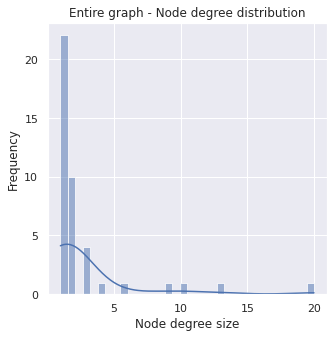

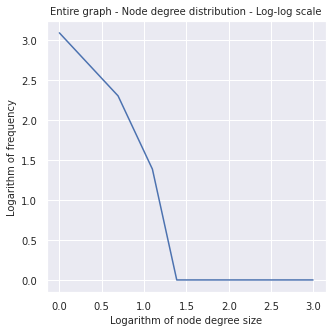

In [ ]:
caviar_net.analyze_single_phase(8)

In [ ]:
caviar_net.graph_nodes_edges()

In [ ]:
caviar_net.show_top_n(10, "eig")

In [ ]:
caviar_net.graph_top_over_time("betw", "betweenness centrality", 10)

In [ ]:
caviar_net.graph_filter_by_node("betw", "Betweenness centrality", ["n1", "n3"])

In [ ]:
caviar_net.graph_global_measure(["density", "transitivity","avg_clustering"])

In [ ]:
caviar_net.graph_global_measure(["greedy_communities", "louvain_communities"])

In [ ]:
caviar_net.graph_global_measure(["triangle"])

Visualize graphs

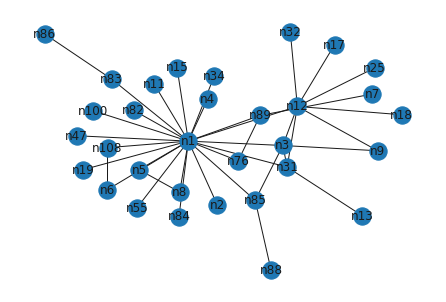

In [ ]:
phase = 5
graph_pos = nx.drawing.nx_agraph.graphviz_layout(G[phase])
nx.draw(G[phase], pos=graph_pos, with_labels=True)

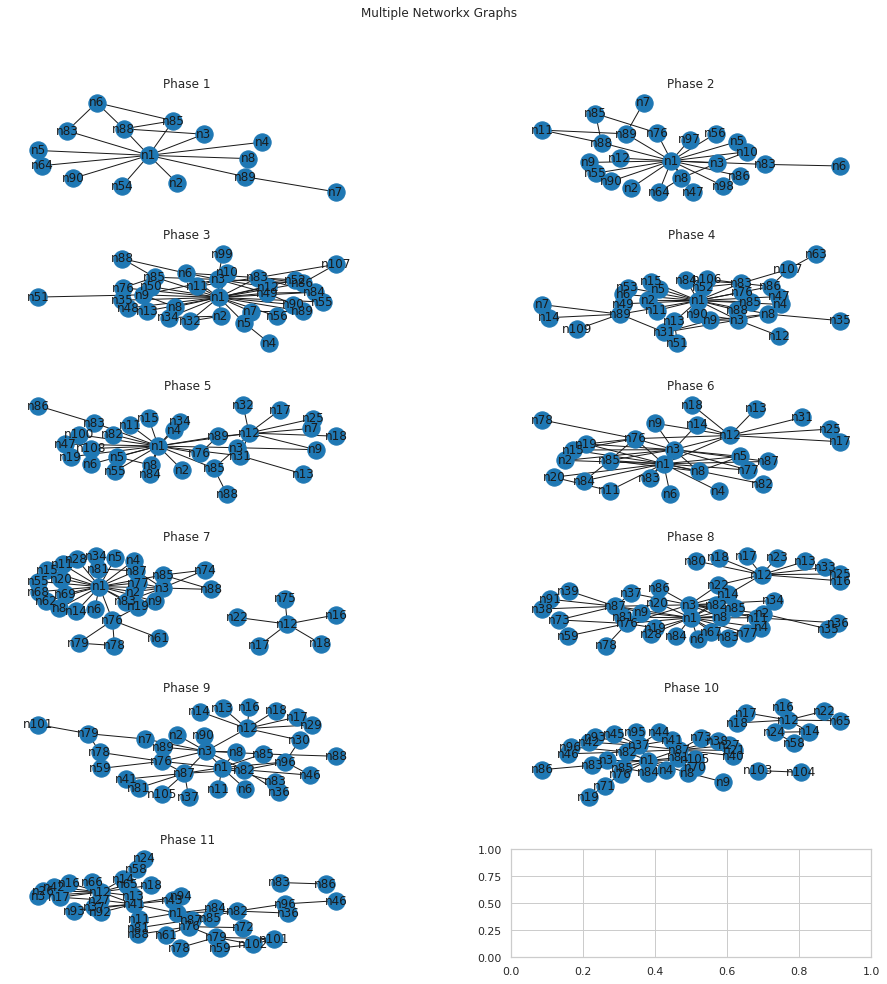

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))

axs_list = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1], axs[2, 0], axs[2, 1], axs[3, 0], axs[3, 1], axs[4, 0], axs[4, 1], axs[5, 0]]

for phase, axis in enumerate(axs_list):
    graph_pos = nx.drawing.nx_agraph.graphviz_layout(G[phase + 1])
    nx.draw(G[phase + 1], pos=graph_pos, ax=axis, with_labels=True)
    axis.set_title(f"Phase {phase + 1}")

# Add a title to the entire figure
fig.suptitle("Multiple Networkx Graphs")

# Adjust the spacing between subplots
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.4, hspace=0.4)


In [ ]:
fig.savefig('myplot.png')

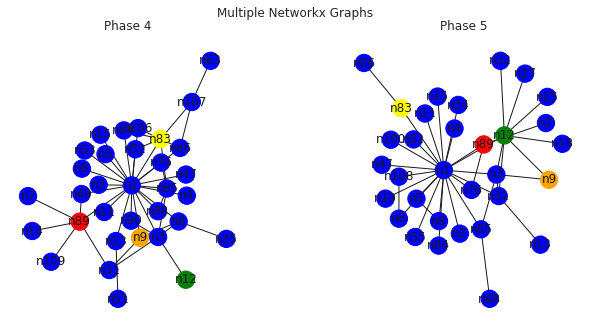

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs_list = [(3, axs[0]), (4, axs[1])]

# Define the nodes to be painted and their colors
nodes_to_paint = ["n12", "n89", "n83", "n9"]
colors = ['green', 'red', 'yellow', 'orange']
node_color_dict = {node: color for node, color in zip(nodes_to_paint, colors)}

for phase, axis in axs_list:
    graph_pos = nx.drawing.nx_agraph.graphviz_layout(G[phase + 1])
    nx.draw(G[phase + 1], pos=graph_pos, ax=axis, with_labels=True, node_color=[node_color_dict.get(node, 'blue') for node in G[phase + 1].nodes()])
    axis.set_title(f"Phase {phase + 1}")

# Add a title to the entire figure
fig.suptitle("Multiple Networkx Graphs")

# Adjust the spacing between subplots
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.4, hspace=0.4)

In [ ]:
phase_c = 7

In [ ]:
G = run_measures(range(1, 12), G)

Time elapsed to compute degree centrality:  0.0008254051208496094
Time elapsed to compute betweenness centrality:  0.030661582946777344
Time elapsed to compute eigenvector centrality:  0.020479679107666016


In [ ]:
{node: value for node, value in G[phase_c].nodes.data("deg") if node in ["n1", "n3", "n12", "n83"]}

{'n1': 0.6857142857142857,
 'n83': 0.08571428571428572,
 'n3': 0.2857142857142857,
 'n12': 0.14285714285714285}

In [ ]:
{node: value for node, value in G[phase_c].nodes.data("betw") if node in ["n1", "n3", "n12", "n83"]}

{'n1': 0.5893557422969188,
 'n83': 0.0,
 'n3': 0.07338935574229691,
 'n12': 0.016806722689075633}

In [ ]:
{node: value for node, value in G[phase_c].nodes.data("eig") if node in ["n1", "n3", "n12", "n83"]}

{'n1': 0.6019866850979453,
 'n83': 0.20026210474717393,
 'n3': 0.3724684836162028,
 'n12': 1.071536546349749e-07}

In [ ]:
caviar_net.show_top_n(10,'betw')

In [ ]:
caviar_net.show_top_n(10,'eig')

In [ ]:
caviar_net.show_top_n(10,'deg')

In [ ]:
caviar_net.graph_top_over_time("deg", "Degree Centrality", 10)

In [ ]:
caviar_net.graph_top_over_time("betw", "Betweenness Centrality", 10)

In [ ]:
caviar_net.graph_top_over_time("eig", "Eigenvector Centrality", 10)

In [ ]:
caviar_net.graph_filter_by_measure("n12", ["betw", "eig"])

In [ ]:
caviar_net.graph_filter_by_measure("n89", ["betw", "eig"])

In [ ]:
caviar_net.graph_filter_by_measure("n83", ["betw", "eig"])

In [ ]:
caviar_net.graph_filter_by_measure("n9", ["betw", "eig"])

Global trends

In [ ]:
caviar_net.graph_global_measure(["density", "transitivity","avg_clustering"])

# Directed graphs

In [ ]:
phases = {}
G = {}
for i in range(1,12):
  var_name = "phase" + str(i)
  file_name = "https://raw.githubusercontent.com/ragini30/Networks-Homework/main/" + var_name + ".csv"
  phases[i] = pd.read_csv(file_name, index_col = ["players"])
  phases[i].columns = "n" + phases[i].columns
  phases[i].index = phases[i].columns
  phases[i][phases[i] > 0] = 1
  G[i] = nx.from_pandas_adjacency(phases[i], create_using=nx.DiGraph)
  G[i].name = var_name

In [ ]:
G[1].is_directed()

True

In [ ]:
twitter_net = Netwokr_over_time(G, range(1, 12), ["deg", "betw", "eig", "hubs", "authorities"])

Time elapsed to compute degree centrality:  0.0010192394256591797
Time elapsed to compute betweenness centrality:  0.06805109977722168
Time elapsed to compute eigenvector centrality:  0.04362297058105469
Time elapsed to compute hubs and authorities:  0.09747695922851562


Graph: 42 nodes, 75 edges
Degree distribution: average = 3.57143, median = 2.00000, standard deviation = 5.31974


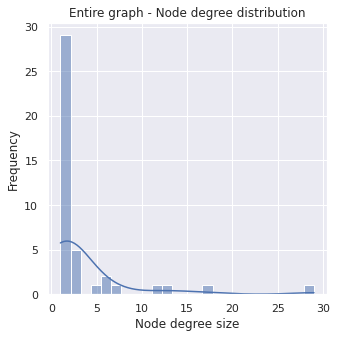

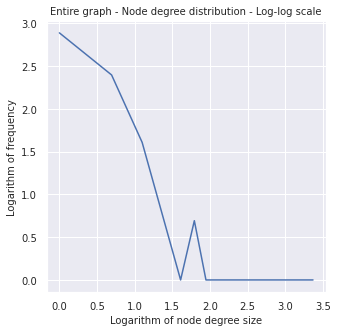

In [ ]:
twitter_net.analyze_single_phase(8)

In [ ]:
{node: value for node, value in twitter_net.G[phase_c].nodes.data("hubs") if node in ["n1", "n3", "n12", "n83"]}

{'n1': 0.2543338098328936,
 'n83': 0.018718130282235027,
 'n3': 0.15915858217344692,
 'n12': -1.2244107135756748e-18}

In [ ]:
twitter_net.graph_filter_by_node("hubs", "hubs score", ["n1", "n3"])

In [ ]:
twitter_net.graph_filter_by_node("authorities", "authorities score", ["n1", "n3"])

In [ ]:
twitter_net.graph_top_over_time("hubs", "hubs score", 10)

In [ ]:
twitter_net.graph_top_over_time("authorities", "authorities score", 10)

# email-Eu network

In [ ]:
import pandas as pd    # for reading and manipulating tabular data
import networkx as nx  # for constructing and studying networks
import numpy as np     # for arrays
#import community           # for community structure later
import collections          # for manipulation tuples and zipping objects
import statistics as stats  # for generating summary statistics
import time                 # for measuring computating time
from matplotlib import pyplot as plt  # for outputting nice plots
import seaborn as sns                 # for creating even nicer plots
import gzip
import datetime

get_ipython().magic(u'matplotlib inline')

In [ ]:
email_data_file = 'email-Eu-core-temporal-Dept1.txt.gz'
directed_G = nx.DiGraph()
directed_G_all = nx.DiGraph()
directed_G = {}
phase_idx = 0
previous_phase = ""

with gzip.open(email_data_file, 'rt') as f:
    for line in f:
        # split the line into node1, node2, and time
        node1, node2, seconds = map(int, line.strip().split())
        time_obj = datetime.datetime.fromtimestamp(seconds)
        current_phase = f"{time_obj.year}-{time_obj.month}"
        if previous_phase != current_phase:
            phase_idx += 1
            directed_G[phase_idx] = nx.DiGraph()
        directed_G[phase_idx].add_edge(node1, node2)
        directed_G_all.add_edge(node1, node2)
        previous_phase = current_phase

In [ ]:
email_eu_net_d1 = Netwokr_over_time(directed_G, range(1, 23), ["deg", "betw", "eig", "closeness", "page_rank", "harmonic", "hubs", "authorities"], directed_G_all)

Time elapsed to compute degree centrality:  0.002135753631591797
Time elapsed to compute betweenness centrality:  0.05149364471435547
Time elapsed to compute eigenvector centrality:  0.019680500030517578
Time elapsed to compute closeness centrality:  0.03888988494873047
Time elapsed to compute page rank:  0.07074189186096191
Time elapsed to compute harmonic centrality:  0.04197359085083008
Time elapsed to compute hubs and authorities:  0.05680727958679199


In [ ]:
email_data_file = 'email-Eu-core-temporal-Dept2.txt.gz'
directed_G = nx.DiGraph()
directed_G_all = nx.DiGraph()
directed_G = {}
phase_idx = 0
previous_phase = ""

with gzip.open(email_data_file, 'rt') as f:
    for line in f:
        # split the line into node1, node2, and time
        node1, node2, seconds = map(int, line.strip().split())
        time_obj = datetime.datetime.fromtimestamp(seconds)
        current_phase = f"{time_obj.year}-{time_obj.month}"
        if previous_phase != current_phase:
            phase_idx += 1
            directed_G[phase_idx] = nx.DiGraph()
        directed_G[phase_idx].add_edge(node1, node2)
        directed_G_all.add_edge(node1, node2)
        previous_phase = current_phase

In [ ]:
email_eu_net_d2 = Netwokr_over_time(directed_G, range(1, 23), ["deg", "betw", "eig", "closeness", "page_rank", "harmonic", "hubs", "authorities"], directed_G_all)

Time elapsed to compute degree centrality:  0.0011165142059326172
Time elapsed to compute betweenness centrality:  0.0374913215637207
Time elapsed to compute eigenvector centrality:  0.017906665802001953
Time elapsed to compute closeness centrality:  0.020416975021362305
Time elapsed to compute page rank:  0.054996490478515625
Time elapsed to compute harmonic centrality:  0.011365652084350586
Time elapsed to compute hubs and authorities:  0.050028324127197266


Graph: 309 nodes, 3031 edges
Degree distribution: average = 19.61812, median = 15.00000, standard deviation = 18.42420


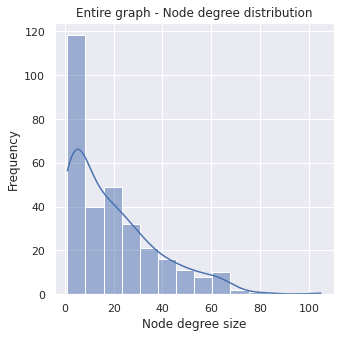

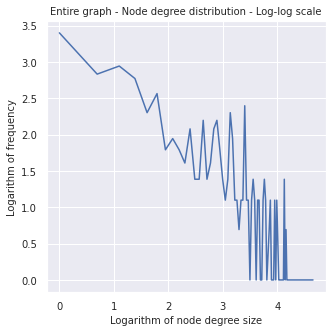

In [ ]:
email_eu_net_d1.analyze_single_phase(2, True)

Graph: 162 nodes, 1772 edges
Degree distribution: average = 21.87654, median = 20.50000, standard deviation = 15.69934


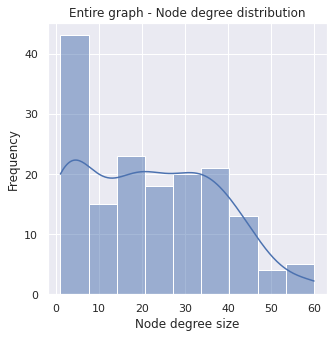

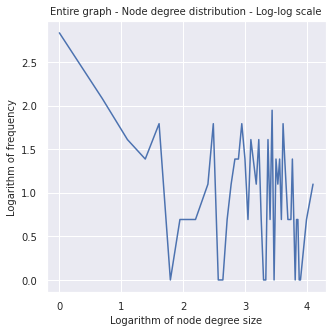

In [ ]:
email_eu_net_d2.analyze_single_phase(2, True)

In [ ]:
email_eu_net_d1.graph_nodes_edges()

In [ ]:
email_eu_net_d2.graph_nodes_edges()

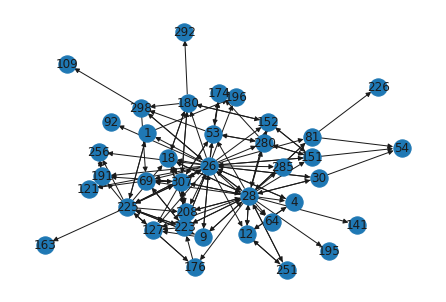

In [ ]:
phase = 1
graph_pos = nx.drawing.nx_agraph.graphviz_layout(email_eu_net_d1.G[phase])
nx.draw(email_eu_net_d1.G[phase], pos=graph_pos, with_labels=True)

In [ ]:
email_eu_net_d1.show_top_n(10,'eig')

In [ ]:
email_eu_net_d1.show_top_n(10,'betw')

In [ ]:
email_eu_net_d1.show_top_n(10,'deg')

In [ ]:
email_eu_net_d2.graph_top_over_time("eig", "Eigenvector Centrality", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("betw", "Betweenness Centrality", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("deg", "Degree Centrality", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("page_rank", "Page rank", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("authorities", "authorities ", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("hubs", "hubs ", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("closeness", "Closeness centrality", 10)

In [ ]:
email_eu_net_d2.graph_top_over_time("harmonic", "Harmonic centrality", 10)

In [ ]:
email_eu_net_d1.graph_filter_by_node("authorities", "authorities score", ["28", "26"])

In [ ]:
email_eu_net_d2.graph_global_measure(["density", "transitivity", "avg_clustering"])

In [ ]:
email_eu_net_d2.graph_global_measure(["density", "transitivity", "avg_clustering"])

In [ ]:
email_eu_net_d1.graph_global_measure(["greedy_communities"])

In [ ]:
email_eu_net_d2.graph_global_measure(["greedy_communities"])

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import levene

def compare_global_measures(graph1, graph2, measure):
    graph1_values = graph1.global_measures[measure]
    graph2_values = graph2.global_measures[measure]
    # Create a trace for measure 1
    trace1 = go.Scatter(x=graph1.x_list, y=graph1_values, name='d1')

    # Create a trace for measure 2
    trace2 = go.Scatter(x=graph2.x_list, y=graph2_values, name='d2')

    # Create a list of traces
    data = [trace1, trace2]

    # Define the layout of the plot
    layout = go.Layout(
        title=dict(text=f'{measure} over Time', xanchor="center", x=0.5),
        xaxis=dict(title='Time period', tickmode='array', tickvals=graph1.x_list),
        yaxis=dict(title='score'),
        legend=dict(title='Measures'),
        width=512, # set the width of the plot in pixels
        height=400 # set the height of the plot in pixels
    )

    # Create the figure
    fig = go.Figure(data=data, layout=layout)

    # Display the plot
    fig.show()


    # perform Shapiro-Wilk test for normality
    stat, p = shapiro(graph1_values)

    # print test results
    print('Shapiro-Wilk test for normality Department 1')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()
    # perform Shapiro-Wilk test for normality
    stat, p = shapiro(graph2_values)

    # print test results
    print('Shapiro-Wilk test for normality Department 2')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()

    # perform Levene's test for equality of variances
    stat, p = levene(graph1_values, graph2_values)

    # print test results
    print('Levene\'s test for equality of variances')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()

    # perform the two-sample t-test
    t_statistic, p_value = ttest_ind(graph1_values, graph2_values)

    # print the results
    print(f"Two-sample t-test for {measure} mean comparison:")
    print()
    print("t-statistic: ", t_statistic)
    print("p-value: ", p_value)
    # check which sample has a higher mean
    if t_statistic > 0 and p_value < 0.05:
        print("Department 1 has a higher mean than Department 2.")
    else:
        print("Department 2 has a higher mean than Department 1.")


In [ ]:
compare_global_measures(email_eu_net_d1, email_eu_net_d2, "density")

Shapiro-Wilk test for normality Department 1
statistic=0.926, p-value=0.101

Shapiro-Wilk test for normality Department 2
statistic=0.935, p-value=0.160

Levene's test for equality of variances
statistic=11.503, p-value=0.002

Two-sample t-test for density mean comparison:

t-statistic:  -8.172840486940956
p-value:  3.2142125439865026e-10
Department 2 has a higher mean than Department 1.


In [ ]:
compare_global_measures(email_eu_net_d1, email_eu_net_d2, "transitivity")

Shapiro-Wilk test for normality Department 1
statistic=0.904, p-value=0.035

Shapiro-Wilk test for normality Department 2
statistic=0.952, p-value=0.343

Levene's test for equality of variances
statistic=3.032, p-value=0.089

Two-sample t-test for transitivity mean comparison:

t-statistic:  -4.082168569116084
p-value:  0.00019556509685503818
Department 2 has a higher mean than Department 1.


In [ ]:
compare_global_measures(email_eu_net_d1, email_eu_net_d2, "avg_clustering")

Shapiro-Wilk test for normality Department 1
statistic=0.887, p-value=0.017

Shapiro-Wilk test for normality Department 2
statistic=0.886, p-value=0.016

Levene's test for equality of variances
statistic=0.199, p-value=0.658

Two-sample t-test for avg_clustering mean comparison:

t-statistic:  -2.9263812832777165
p-value:  0.005513164893066793
Department 2 has a higher mean than Department 1.


In [ ]:
compare_global_measures(email_eu_net_d1, email_eu_net_d2, "greedy_communities")

Shapiro-Wilk test for normality Department 1
statistic=0.862, p-value=0.006

Shapiro-Wilk test for normality Department 2
statistic=0.766, p-value=0.000

Levene's test for equality of variances
statistic=0.226, p-value=0.637

Two-sample t-test for greedy_communities mean comparison:

t-statistic:  6.333987921134255
p-value:  1.3132432157717706e-07
Department 1 has a higher mean than Department 2.


In [ ]:
def compare_individual_top_measures(graph1, graph2, measure, top):
    sorted_dict1 = dict(sorted(graph1.nodes_measures_summary.items(), key=lambda item: item[1][measure], reverse=True))
    sorted_dict2 = dict(sorted(graph2.nodes_measures_summary.items(), key=lambda item: item[1][measure], reverse=True))

    # print the sorted dictionary
    top_list = [key for idx, (key, val) in enumerate(sorted_dict1.items()) if idx < top]
    top_mean_1 = np.mean([graph1.nodes_measures[node][measure] for node in top_list], axis=0)
    trace1 = go.Scatter(x=graph1.x_list, y=top_mean_1, name='d1')

    top_list = [key for idx, (key, val) in enumerate(sorted_dict2.items()) if idx < top]
    top_mean_2 = np.mean([graph2.nodes_measures[node][measure] for node in top_list], axis=0)
    trace2 = go.Scatter(x=graph2.x_list, y=top_mean_2, name='d2')

    # Create a list of traces
    data = [trace1, trace2]

    # Define the layout of the plot
    layout = go.Layout(
        title=dict(text=f'Top {top} average of {measure} over Time', xanchor="center", x=0.5),
        xaxis=dict(title='Time period', tickmode='array', tickvals=graph1.x_list),
        yaxis=dict(title='score'),
        legend=dict(title='Measures'),
        width=512, # set the width of the plot in pixels
        height=400 # set the height of the plot in pixels
    )

    # Create the figure
    fig = go.Figure(data=data, layout=layout)

    # Display the plot
    fig.show()

    # perform Shapiro-Wilk test for normality
    stat, p = shapiro(top_mean_1)

    # print test results
    print('Shapiro-Wilk test for normality Department 1')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()
    # perform Shapiro-Wilk test for normality
    stat, p = shapiro(top_mean_2)

    # print test results
    print('Shapiro-Wilk test for normality Department 2')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()

    # perform Levene's test for equality of variances
    stat, p = levene(top_mean_1, top_mean_2)

    # print test results
    print('Levene\'s test for equality of variances')
    print(f'statistic={stat:.3f}, p-value={p:.3f}')
    print()

    # perform the two-sample t-test
    t_statistic, p_value = ttest_ind(top_mean_1, top_mean_2)

    # print the results
    print(f"Two-sample t-test for {measure} mean comparison:")
    print()
    print("t-statistic: ", t_statistic)
    print("p-value: ", p_value)
    # check which sample has a higher mean
    if t_statistic > 0 and p_value < 0.05:
        print("Department 1 has a higher mean than Department 2.")
    else:
        print("Department 2 has a higher mean than Department 1.")

In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "betw", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.879, p-value=0.012

Shapiro-Wilk test for normality Department 2
statistic=0.945, p-value=0.255

Levene's test for equality of variances
statistic=0.646, p-value=0.426

Two-sample t-test for betw mean comparison:

t-statistic:  0.5212606236391676
p-value:  0.6049230683124311
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "deg", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.854, p-value=0.004

Shapiro-Wilk test for normality Department 2
statistic=0.910, p-value=0.047

Levene's test for equality of variances
statistic=4.930, p-value=0.032

Two-sample t-test for deg mean comparison:

t-statistic:  -2.442513633783928
p-value:  0.01887379741843584
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "eig", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.725, p-value=0.000

Shapiro-Wilk test for normality Department 2
statistic=0.518, p-value=0.000

Levene's test for equality of variances
statistic=1.236, p-value=0.272

Two-sample t-test for eig mean comparison:

t-statistic:  -0.4798213830875618
p-value:  0.6338438217163833
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "page_rank", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.957, p-value=0.432

Shapiro-Wilk test for normality Department 2
statistic=0.550, p-value=0.000

Levene's test for equality of variances
statistic=1.460, p-value=0.234

Two-sample t-test for page_rank mean comparison:

t-statistic:  -3.3180249763938647
p-value:  0.0018790835228871833
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "closeness", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.854, p-value=0.004

Shapiro-Wilk test for normality Department 2
statistic=0.839, p-value=0.002

Levene's test for equality of variances
statistic=0.600, p-value=0.443

Two-sample t-test for closeness mean comparison:

t-statistic:  -0.5181469492720551
p-value:  0.6070747319013046
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "hubs", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.947, p-value=0.281

Shapiro-Wilk test for normality Department 2
statistic=0.491, p-value=0.000

Levene's test for equality of variances
statistic=0.660, p-value=0.421

Two-sample t-test for hubs mean comparison:

t-statistic:  -2.3580139271764384
p-value:  0.02310491025175284
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "authorities", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.839, p-value=0.002

Shapiro-Wilk test for normality Department 2
statistic=0.581, p-value=0.000

Levene's test for equality of variances
statistic=0.150, p-value=0.701

Two-sample t-test for authorities mean comparison:

t-statistic:  -3.39385945119864
p-value:  0.001514531042537661
Department 2 has a higher mean than Department 1.


In [ ]:
compare_individual_top_measures(email_eu_net_d1, email_eu_net_d2, "harmonic", 10)

Shapiro-Wilk test for normality Department 1
statistic=0.769, p-value=0.000

Shapiro-Wilk test for normality Department 2
statistic=0.794, p-value=0.000

Levene's test for equality of variances
statistic=1.203, p-value=0.279

Two-sample t-test for harmonic mean comparison:

t-statistic:  4.601581870131854
p-value:  3.838164880684286e-05
Department 1 has a higher mean than Department 2.
